<a href="https://colab.research.google.com/github/ChloeZhou1997/BreastCancerCNN/blob/main/Breast_Cancer_Detection_Project_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prep

1. connect to google drive where data are stored
2. install *pylibjpeg* and *pydicom* according to the [duke repo](https://github.com/MaciejMazurowski/duke-dbt-data)
3. get helper function from duck repo mentioned before (the image is 3D and cannot be displayed using conventional python liberary) 

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pylibjpeg==1.1.1
!pip install pydicom==2.1.1
!pip install torchmetrics
!pip install pytorch_lightning
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

Mounted at /content/drive
     |████████████████████████████████| 1.3 MB 21.8 MB/s 
     |████████████████████████████████| 1.9 MB 14.8 MB/s 
     |████████████████████████████████| 408 kB 14.5 MB/s 
     |████████████████████████████████| 582 kB 14.0 MB/s 
     |████████████████████████████████| 596 kB 65.2 MB/s 
     |████████████████████████████████| 136 kB 77.8 MB/s 
     |████████████████████████████████| 1.1 MB 58.9 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 51.7 MB/s 
     |████████████████████████████████| 144 kB 77.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random

## Obtain the normalizer of the graph

In [3]:
# ROOT_PATH = '/content/drive/MyDrive/Data/processed/training'

# normalizer = 225*225

# file_num = 0

# sum,sum_squared = 0,0

# for folder in os.listdir(ROOT_PATH):
#   new_path = os.path.join(ROOT_PATH,folder)
#   for file in os.listdir(new_path):
#     if file == ".ipynb_checkpoints":
#       continue
#     file_path = os.path.join(new_path,file)
#     file_num += 1
#     image = np.load(file_path).astype(np.float32)
#     sum += np.sum(image)/normalizer
#     sum_squared += (image ** 2).sum()/normalizer

# mean = sum/file_num
# std = np.sqrt(sum_squared/file_num -mean )


In [8]:
# from pathlib import Path

# normalizers = mean,std

# path = Path("/content/drive/MyDrive/Project")

# np.save(path/'normalizer', normalizers)

In [ ]:
# img = np.load('/content/drive/MyDrive/Data/processed/training/Cancer/DBT-P00194_rmlo.npy').astype(np.float32)
# plt.imshow(img, cmap='gray')
# plt.show()

In [17]:
normalizer = np.load('/content/drive/MyDrive/Project/normalizer.npy')
mean = normalizer[0]
std = normalizer[1]

# Preprossing Data

In [4]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
# from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np

In [12]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [18]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std),
                                       ]
)

val_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std),                                     
])

In [19]:
train_dataset = torchvision.datasets.DatasetFolder("/content/drive/MyDrive/Data/processed/training",
                                                   loader = load_file,
                                                   extensions = "npy",
                                                   transform = train_transforms)

val_dataset = torchvision.datasets.DatasetFolder("/content/drive/MyDrive/Data/processed/validation",
                                                   loader = load_file,
                                                   extensions = "npy",
                                                   transform = train_transforms)

In [20]:
 # Check the number of samples in corresponding labels
 
 np.unique(train_dataset.targets,return_counts = True)

(array([0, 1]), array([8213, 9215]))

In [25]:
np.unique(val_dataset.targets,return_counts = True)

(array([0, 1]), array([5560, 5185]))

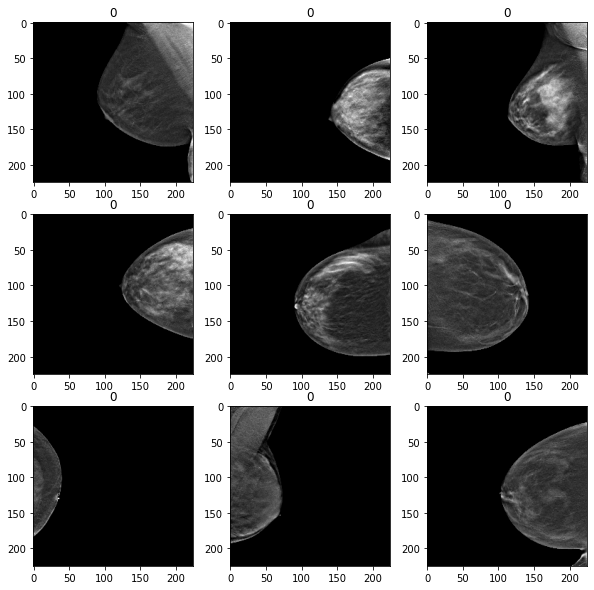

In [21]:
fig,axis = plt.subplots(3,3,figsize = (10,10))

for i in range(3):
  for j in range(3):
    random_index = np.random.randint(0,100)
    img, label = val_dataset[random_index]
    axis[i][j].imshow(img[0], cmap = "gray")
    axis[i][j].set_title(label)

In [20]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

# Model creation

##ResNet50

In [25]:
# torchvision.models.resnet152()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import torchmetrics

class CheastCancer_ResNet(pl.LightningModule):

  def __init__(self,init_weights=True):
    super().__init__()

    self.model = torchvision.models.resnet152()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
 

    #loss function
    self.criterion = torch.nn.BCEWithLogitsLoss()

    #eval matrix
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

    #list to store loss curve and accuracy curve
    self.traincc, self.valacc = [],[]
    self.trainloss, self.valloss = [],[0]

  def forward(self, data):
    pred = self.model(data)
    return pred

  def training_step(self, batch, batch_idx):
    img, label = batch
    pred = self(img)
    # label = label.float()
    loss = self.criterion(pred[:,0],label.float())
    acc = self.train_acc(pred[:,0],label)

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred[:,0]), label.int()))

    return loss
  
  def training_epoch_end(self, outs):
    self.log("Train ACC", self.train_acc.compute())

  def validation_step(self, batch, batch_idx):
    img, label = batch
    # label = label.float()
    pred = self(img)
    # loss = self.loss_fn(pred,label)
    loss = self.criterion(pred[:,0],label.float())

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.val_acc(torch.sigmoid(pred[:,0]), label.int()))

  
  def validation_epoch_end(self, outs):
    self.log("Val ACC", self.val_acc.compute())

  def configure_optimizers(self):
      return [self.optimizer]

### Training

In [28]:
model = CheastCancer_ResNet()

In [30]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "/content/drive/MyDrive/Project/checkpoint/ResNet",
    filename="sample-breastcancer-{epoch:02d}-{Val ACC:.2f}",
    monitor = "Val ACC",
    save_top_k = 10,
    mode ="max")

In [31]:
gpus = 1
trainer = pl.Trainer(gpus = gpus, logger = TensorBoardLogger(save_dir = "/content/drive/MyDrive/Project/logs/ResNet"), log_every_n_steps = 1,
                     callbacks = checkpoint_callback, max_epochs = 700)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
def evaluation(model, dataloader):
  predictions, labels = [], []
  with torch.no_grad():
    for batch in dataloader:
      batch = [term.cuda() for term in batch]
      pred = model(batch[0]).squeeze(1)
      pred = torch.sigmoid(pred)
      pred = [1 if p >= 0.5 else 0 for p in pred]
      predictions += pred
      labels += batch[1]
  
  result = 0
  for p, l in zip(predictions, labels):

    if p == l:
      result += 1
    else:
      continue
  accuracy = result / len(labels)
  return accuracy

In [ ]:
import tqdm
best_accuracy = float('-inf')
# state_dict = torch.load('file_path')
# model.load_state_dict(state_dict)
step = 0
patinet = 0
stop_train = False
model = CheastCancer_ResNet()
model = model.cuda()
for epoch in range(200):
  bar = tqdm.trange(len(train_loader))
  total_loss = 0
  for epoch_step, batch in zip(bar, train_loader):
    model.optimizer.zero_grad()
    model.train()
    batch = [term.cuda() for term in batch]

    pred = model(batch[0])
    loss = model.criterion(pred.squeeze(1), batch[1].float())

    loss.backward()
    total_loss += loss.item()
    model.optimizer.step()
    bar.set_postfix(avg_loss='{}'.format(total_loss / (epoch_step+1)))

    if step % 100 == 0 and step != 0:
      model.eval()
      val_accu = evaluation(model, val_loader)
      print('Val Accuracy: {}'.format(val_accu))

      if val_accu >= best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Project/checkpoint/ResNet/checkpoint_ACC_{}.ckpt'.format(val_accu))
        patient = 0
      else:
        patient += 1
      
      if patient == 5:
        stop_train = True
        break
    step += 1
  if stop_train:
    print('Stop Training !')
    break

 33%|███▎      | 100/299 [05:36<12:02,  3.63s/it, avg_loss=0.7006523609161377]

Val Accuracy: 0.5280595625872498


 67%|██████▋   | 200/299 [11:59<06:00,  3.64s/it, avg_loss=0.6870739305790384]

Val Accuracy: 0.5216379711493718


  0%|          | 1/299 [00:01<04:39,  1.07it/s, avg_loss=0.561159074306488] 

Val Accuracy: 0.657235923685435


 34%|███▍      | 101/299 [02:36<03:06,  1.06it/s, avg_loss=0.5322539929081412]

Val Accuracy: 0.7154955793392276


 67%|██████▋   | 201/299 [05:11<01:32,  1.06it/s, avg_loss=0.5072313907122848]

Val Accuracy: 0.7704048394602141


  1%|          | 2/299 [00:02<04:40,  1.06it/s, avg_loss=0.34575361510117847]

Val Accuracy: 0.808189855746859


 34%|███▍      | 102/299 [02:37<03:05,  1.06it/s, avg_loss=0.3180259469064694]

Val Accuracy: 0.8682177757096324


 68%|██████▊   | 202/299 [05:12<01:31,  1.06it/s, avg_loss=0.28830305780536436]

Val Accuracy: 0.9129827826896231


  1%|          | 3/299 [00:03<04:42,  1.05it/s, avg_loss=0.14274417981505394]

Val Accuracy: 0.9218241042345277


 34%|███▍      | 103/299 [02:39<03:04,  1.06it/s, avg_loss=0.15558271292740336]

Val Accuracy: 0.9152163797114937


 68%|██████▊   | 203/299 [05:14<01:30,  1.06it/s, avg_loss=0.1559516922479459] 

Val Accuracy: 0.9322475570032573


  1%|▏         | 4/299 [00:04<04:37,  1.06it/s, avg_loss=0.07122951745986938]

Val Accuracy: 0.9495579339227548


 35%|███▍      | 104/299 [02:39<03:04,  1.06it/s, avg_loss=0.0855279825893896] 

Val Accuracy: 0.9504885993485342


 68%|██████▊   | 204/299 [05:13<01:29,  1.06it/s, avg_loss=0.09492986904139199]

Val Accuracy: 0.9435086086551885


  2%|▏         | 5/299 [00:05<04:36,  1.06it/s, avg_loss=0.11153098195791245]

Val Accuracy: 0.9472312703583062


 35%|███▌      | 105/299 [02:40<03:02,  1.06it/s, avg_loss=0.07246952032108071]

Val Accuracy: 0.9659376454164728


 69%|██████▊   | 205/299 [05:14<01:28,  1.06it/s, avg_loss=0.06452223519315418]

Val Accuracy: 0.9789669613773848


  2%|▏         | 6/299 [00:06<04:37,  1.06it/s, avg_loss=0.07723937808935132]

Val Accuracy: 0.9423918101442531


 35%|███▌      | 106/299 [02:41<03:01,  1.06it/s, avg_loss=0.07621579612909912]

Val Accuracy: 0.975430432759423


 69%|██████▉   | 206/299 [05:14<01:27,  1.06it/s, avg_loss=0.06382767419929161]

Val Accuracy: 0.9744067007910656


  2%|▏         | 7/299 [00:07<04:34,  1.07it/s, avg_loss=0.05691169179044664]

Val Accuracy: 0.9696603071195905


 36%|███▌      | 107/299 [02:41<03:00,  1.07it/s, avg_loss=0.03923765048858951]

Val Accuracy: 0.9771986970684039


 69%|██████▉   | 207/299 [05:16<01:26,  1.06it/s, avg_loss=0.044585715924488165]

Val Accuracy: 0.9742205677059097


  3%|▎         | 8/299 [00:08<04:34,  1.06it/s, avg_loss=0.04177934407360024]

Val Accuracy: 0.9631456491391345


 36%|███▌      | 108/299 [02:42<03:00,  1.06it/s, avg_loss=0.0414631848454202] 

Val Accuracy: 0.9736621684504421


 70%|██████▉   | 208/299 [05:17<01:25,  1.06it/s, avg_loss=0.03630859505732736]

Val Accuracy: 0.9744067007910656


  3%|▎         | 9/299 [00:09<04:31,  1.07it/s, avg_loss=0.04042375897988677]

Val Accuracy: 0.9691019078641229


 36%|███▋      | 109/299 [02:43<02:58,  1.06it/s, avg_loss=0.03445353543237698]

Val Accuracy: 0.9805490926012098


 70%|██████▉   | 209/299 [05:17<01:24,  1.06it/s, avg_loss=0.039447583933360876]

Val Accuracy: 0.9650069799906933


  3%|▎         | 10/299 [00:10<04:31,  1.07it/s, avg_loss=0.04024513239379634]

Val Accuracy: 0.965472312703583


 37%|███▋      | 110/299 [02:44<02:57,  1.06it/s, avg_loss=0.029617908222995162]

Val Accuracy: 0.9796184271754305


 70%|███████   | 210/299 [05:18<01:23,  1.06it/s, avg_loss=0.030524336241331322]

Val Accuracy: 0.9763610981852024


  4%|▎         | 11/299 [00:11<04:30,  1.06it/s, avg_loss=0.05282056890428066]

Val Accuracy: 0.9574685900418799


 37%|███▋      | 111/299 [02:46<02:57,  1.06it/s, avg_loss=0.05156798652024008]

Val Accuracy: 0.975430432759423


 71%|███████   | 211/299 [05:21<01:23,  1.06it/s, avg_loss=0.04334566539772874]

Val Accuracy: 0.9857608189855747


  4%|▍         | 12/299 [00:12<04:31,  1.06it/s, avg_loss=0.030453202708695944]

Val Accuracy: 0.980362959516054


 37%|███▋      | 112/299 [02:47<02:55,  1.06it/s, avg_loss=0.021822928278181553]

Val Accuracy: 0.9787808282922289


 71%|███████   | 212/299 [05:21<01:21,  1.06it/s, avg_loss=0.024300312091177768]

Val Accuracy: 0.9776640297812936


  4%|▍         | 13/299 [00:13<04:30,  1.06it/s, avg_loss=0.059765090101531575]

Val Accuracy: 0.9560725919032108


 38%|███▊      | 113/299 [02:47<02:55,  1.06it/s, avg_loss=0.0660237178835495] 

Val Accuracy: 0.9702187063750581


 71%|███████   | 213/299 [05:22<01:20,  1.06it/s, avg_loss=0.05230853992087819]

Val Accuracy: 0.9788738948348069


  5%|▍         | 14/299 [00:14<04:27,  1.06it/s, avg_loss=0.015674521727487446]

Val Accuracy: 0.9821312238250349


 38%|███▊      | 114/299 [02:48<02:53,  1.06it/s, avg_loss=0.02135938899287873] 

Val Accuracy: 0.9725453699395068


 72%|███████▏  | 214/299 [05:23<01:20,  1.06it/s, avg_loss=0.028890665966021113]

Val Accuracy: 0.9777570963238715


  5%|▌         | 15/299 [00:15<04:26,  1.06it/s, avg_loss=0.020759108796482906]

Val Accuracy: 0.9792461610051186


 38%|███▊      | 115/299 [02:49<02:52,  1.07it/s, avg_loss=0.029238643360540977]

Val Accuracy: 0.9691019078641229


 72%|███████▏  | 215/299 [05:24<01:18,  1.06it/s, avg_loss=0.03141587179130444]

Val Accuracy: 0.9731037691949744


  5%|▌         | 16/299 [00:16<04:26,  1.06it/s, avg_loss=0.024319831768105572]

Val Accuracy: 0.9873429502093998


 39%|███▉      | 116/299 [02:50<02:51,  1.06it/s, avg_loss=0.018522703383340795]

Val Accuracy: 0.9769194974406701


 72%|███████▏  | 216/299 [05:24<01:18,  1.06it/s, avg_loss=0.020741781870049127]

Val Accuracy: 0.981945090739879


  6%|▌         | 17/299 [00:16<04:24,  1.07it/s, avg_loss=0.010596429405268282]

Val Accuracy: 0.9861330851558865


 39%|███▉      | 117/299 [02:51<02:50,  1.07it/s, avg_loss=0.009213080504411926]

Val Accuracy: 0.9870637505816658


 73%|███████▎  | 217/299 [05:26<01:17,  1.06it/s, avg_loss=0.02447543371450893] 

Val Accuracy: 0.9363424848766868


  6%|▌         | 18/299 [00:17<04:24,  1.06it/s, avg_loss=0.040679104859009385]

Val Accuracy: 0.980362959516054


 39%|███▉      | 118/299 [02:52<02:50,  1.06it/s, avg_loss=0.0242624101277926] 

Val Accuracy: 0.9764541647277803


 73%|███████▎  | 218/299 [05:27<01:16,  1.06it/s, avg_loss=0.03336871782430452]

Val Accuracy: 0.9768264308980922


  6%|▋         | 19/299 [00:18<04:23,  1.06it/s, avg_loss=0.017767445754725487]

Val Accuracy: 0.9809213587715216


 40%|███▉      | 119/299 [02:53<02:50,  1.06it/s, avg_loss=0.016132795980471806]

Val Accuracy: 0.9796184271754305


 73%|███████▎  | 219/299 [05:28<01:15,  1.06it/s, avg_loss=0.0288950534383978]  

Val Accuracy: 0.962214983713355


  7%|▋         | 20/299 [00:19<04:21,  1.07it/s, avg_loss=0.02107709415057408] 

Val Accuracy: 0.9791530944625407


 40%|████      | 120/299 [02:54<02:48,  1.06it/s, avg_loss=0.022183358065797448]

Val Accuracy: 0.9831549557933923


 74%|███████▎  | 220/299 [05:28<01:14,  1.06it/s, avg_loss=0.021620119015166823]

Val Accuracy: 0.9774778966961377


  7%|▋         | 21/299 [00:20<04:21,  1.06it/s, avg_loss=0.022046109026467257]

Val Accuracy: 0.9651000465332713


 40%|████      | 121/299 [02:55<02:47,  1.06it/s, avg_loss=0.02481426239217876] 

Val Accuracy: 0.9776640297812936


 74%|███████▍  | 221/299 [05:29<01:13,  1.06it/s, avg_loss=0.02917391882012682]

Val Accuracy: 0.9691949744067008


  7%|▋         | 22/299 [00:21<04:19,  1.07it/s, avg_loss=0.031005163828882833]

Val Accuracy: 0.965472312703583


 41%|████      | 122/299 [02:56<02:45,  1.07it/s, avg_loss=0.036763150496711215]

Val Accuracy: 0.9731037691949744


 74%|███████▍  | 222/299 [05:30<01:12,  1.06it/s, avg_loss=0.030202839098872843]

Val Accuracy: 0.9906933457422057


  8%|▊         | 23/299 [00:22<04:19,  1.06it/s, avg_loss=0.015364612001576461]

Val Accuracy: 0.9790600279199628


 41%|████      | 123/299 [02:57<02:45,  1.06it/s, avg_loss=0.013777164817926655]

Val Accuracy: 0.9817589576547231


 75%|███████▍  | 223/299 [05:32<01:11,  1.06it/s, avg_loss=0.015508430438460761]

Val Accuracy: 0.9822242903676128


  4%|▍         | 12/299 [00:12<04:29,  1.06it/s, avg_loss=0.03926547117029818] 

In [34]:
# trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 58.1 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
58.1 M    Trainable params
0         Non-trainable params
58.1 M    Total params
232.558   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Evaluation

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CheastCancer_ResNet()
# model = model.cuda()

state_dict = torch.load('/content/drive/MyDrive/Project/checkpoint/ResNet/checkpoint_ACC_0.9906933457422057.ckpt')
model.load_state_dict(state_dict)

# model = CheastCancer_ResNet.load_from_checkpoint("/content/drive/MyDrive/Project/checkpoint/ResNet/checkpoint_ACC_0.9906933457422057.ckpt")
# model.eval()

preds = []
labels = []

with torch.no_grad():
  correct = 0
  for data, label in tqdm(val_dataset):
    data = data.float().unsqueeze(0)
    pred = torch.sigmoid(model(data)[0])
    preds.append(pred)
    labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

acc = torchmetrics.Accuracy()(preds,labels)
precision = torchmetrics.Precision()(preds,labels)
recall = torchmetrics.Recall()(preds,labels)
cm = torchmetrics.ConfusionMatrix(num_classes = 2)(preds,labels)

print(f"Val Accuracy:{acc}")
print(f"Val Precision:{precision}")
print(f"Val Recall:{recall}")
print(f"Confusion Matrix:{cm}")

  0%|          | 0/10745 [00:00<?, ?it/s]

Val Accuracy:0.8265239596366882
Val Precision:0.9154365658760071
Val Recall:0.7056894898414612
Confusion Matrix:tensor([[5222,  338],
        [1526, 3659]])
